In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('data')
import torch
import random
from os.path import join
# from utils import *
from data.paths import MAIN_DIR_PATH
pd.set_option('display.max_colwidth', 1000)
OUTPUT_FOLDER = join(MAIN_DIR_PATH, 'data/outputs/model_outputs') 
TRADE_PATH = join(MAIN_DIR_PATH,'data/TRADE.csv' ) 

# what do we need image foler for??
IMAGE_FOLDER = '/Users/anna/Documents/Code/Ads/data/images'


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## CLIP

In [2]:
embs = torch.load(join(OUTPUT_FOLDER,'clip_outputs_300'), map_location=torch.device('cpu'))
print(embs.keys())
images = embs['images'].to(torch.float32)
ar = embs['ar'].to(torch.float32)
d1 = embs['dist1'].to(torch.float32)
d2 = embs['dist2'].to(torch.float32)

dict_keys(['images', 'ar', 'dist1', 'dist2', 'model_checkpoint'])


In [22]:
n = images.size()[0]
print(n)
emb_dim = images.size()[1]
cands = torch.stack((ar, d1, d2), dim=1)
end_mat = torch.bmm(images.view((n,1,emb_dim)), 
                    cands.transpose(1,2)).view(n,3)
print(end_mat.size())
print(f'CLIP achieves an accuracy of: {round((end_mat.argmax(dim=1)==0).sum().item()/n,2)}')
t = ((torch.argsort(end_mat, dim=1, descending=True))[:,0]).to(torch.float32)
print(f'Rank: {round(t.mean().item(), 2)}, std: {round(t.std().item(), 2)}')

300
torch.Size([300, 3])
CLIP achieves an accuracy of: 0.34
Rank: 0.97, std: 0.8


With the HF embeddings

In [6]:
import pickle
import sys
sys.path.append(OUTPUT_PATH) 
from bert_utils import SentenceEmbeddings
OUTPUT_PATH = '/Users/anna/Documents/Code/Ads/data/outputs'
df = pd.read_csv(join(OUTPUT_PATH, 'dist_w_ocr.csv'))

In [19]:
clip_our_dataset.out_dict['142269.jpg'].keys()

dict_keys(['logits', 'image_embedding', 'text_embedding', 'sentences'])

In [7]:
clip_our_dataset = pickle.load(open(join(OUTPUT_PATH, 'clip','clip-vit-large-patch14-336_clip_score_our_dataset.pkl'), "rb"))
clip_scores_right = np.array([clip_our_dataset.out_dict[df.image_path[i]]['logits'][0] for i in range(len(df))])
clip_scores_wrong = np.array([clip_our_dataset.out_dict[df.image_path[i]]['logits'][1:] for i in range(len(df))]).flatten()

In [14]:
clip_our_dataset.out_dict['111237.jpg']['image_embedding'].shape

(1, 768)

In [23]:
clip_our_dataset.out_dict['111237.jpg']['text_embedding']

array([[ 6.97131753e-02,  5.26530156e-03,  1.02878362e-02,
         4.97484617e-02,  4.06392962e-02, -1.01224743e-02,
         6.96552033e-03,  8.56123026e-03, -2.05226894e-03,
        -1.74253359e-02, -2.64374726e-02, -1.08526917e-02,
         3.26379016e-02,  2.61310413e-02, -1.66783947e-02,
         1.47600695e-02, -3.36474180e-02,  2.17110459e-02,
         1.83204710e-02, -1.21359210e-02, -3.51895839e-02,
         3.16098444e-02,  6.48973929e-03,  8.40354618e-03,
        -1.19153149e-02,  2.25260910e-02,  4.39704163e-03,
        -5.20427013e-03,  2.51785410e-03,  7.96347111e-03,
        -1.99237540e-02, -2.83271726e-02,  1.13864674e-03,
        -4.41654660e-02, -7.00298771e-02, -3.97471152e-02,
        -5.21527231e-03, -4.25162390e-02, -1.47452960e-02,
        -3.77658848e-03, -1.81356631e-02,  3.21011618e-02,
         4.82478961e-02, -4.42236029e-02,  2.73739290e-03,
         3.37373540e-02, -6.78405399e-03,  1.36313234e-02,
         6.59100013e-03,  5.06062759e-03, -4.12224196e-0

In [17]:
clip_our_dataset.out_dict['111237.jpg']['logits'].shape

(3,)

## ALIGN

In [5]:
embs = torch.load(join(OUTPUT_FOLDER,'align_outputs_aggregated'), map_location=torch.device('cpu'))
print(embs.keys())
images = embs['images'].to(torch.float32)
ar = embs['ar'].to(torch.float32)
d1 = embs['dist1'].to(torch.float32)
d2 = embs['dist2'].to(torch.float32)
# d1 = embs['dist1'].to(torch.float32)[idxs2]
# d2 = embs['dist2'].to(torch.float32)[idxs3]

dict_keys(['images', 'ar', 'dist1', 'dist2', 'model_checkpoint'])


In [6]:
n = images.size()[0]
print(n, 'samples')
emb_dim = images.size()[1]
cands = torch.stack((ar, d1, d2), dim=1)
temperature = 0.0146

# cands = torch.stack((ar, ar[idxs1], ar[idxs2]), dim=1)

end_mat = torch.bmm(images.view((n,1,emb_dim)), 
                    cands.transpose(1,2)).view(n,3)/temperature
end_mat.size()
print(f'ALIGN achieves an accuracy of: {round((end_mat.argmax(dim=1)==0).sum().item()/n,2)}')
t = (torch.argsort(end_mat, dim=1, descending=True)[:,0]).to(torch.float32)
print(f'Rank: {round(t.mean().item(), 2)} , std: {round(t.std().item(), 2)}')

300 samples
ALIGN achieves an accuracy of: 0.28
Rank: 1.04 , std: 0.77


## ALBEF

In [7]:
embs = torch.load(join(OUTPUT_FOLDER,'albef_outputs_aggregated'), map_location=torch.device('cpu'))
images = embs['images'].to(torch.float32)
ar = embs['ar'].to(torch.float32)
d1 = embs['dist1'].to(torch.float32)
d2 = embs['dist2'].to(torch.float32)

# d1 = embs['dist1'].to(torch.float32)[idxs2]
# d2 = embs['dist2'].to(torch.float32)[idxs3]

In [8]:
n = images.size()[0]
emb_dim = images.size()[1]
cands = torch.stack((ar, d1, d2), dim=1)
# cands = torch.stack((ar, ar[idxs1], ar[idxs2]), dim=1)
temperature = 0.0045
end_mat = torch.bmm(images.view((n,1,emb_dim)), 
                    cands.transpose(1,2)).view(n,3)/temperature
print(end_mat.size())
print(f'ALBEF achieves an accuracy of: {round((end_mat.argmax(dim=1)==0).sum().item()/n,2)}')
t = (torch.argsort(end_mat, dim=1, descending=True)[:,0]).to(torch.float32)
print(f'Rank: {round(t.mean().item(), 2)}, std: {round(t.std().item(), 2)}')

torch.Size([300, 3])
ALBEF achieves an accuracy of: 0.33
Rank: 1.02, std: 0.83


## LiT

In [9]:
embs = torch.load(join(OUTPUT_FOLDER, 'lit_outputs_aggregated'), map_location=torch.device('cpu'))
print(embs.keys())
images = embs['images'].to(torch.float32)
ar = embs['ar'].to(torch.float32)
d1 = embs['dist1'].to(torch.float32)
d2 = embs['dist2'].to(torch.float32)

# d1 = embs['dist1'].to(torch.float32)[idxs2]
# d2 = embs['dist2'].to(torch.float32)[idxs3]

dict_keys(['images', 'ar', 'dist1', 'dist2', 'model_checkpoint', 'temperature'])


In [10]:
n = images.size()[0]
emb_dim = images.size()[1]
cands = torch.stack((ar, d1, d2), dim=1)
# cands = torch.stack((ar, ar[idxs1], ar[idxs2]), dim=1)

end_mat = torch.bmm(images.view((n,1,emb_dim)), 
                    cands.transpose(1,2)).view(n,3)
print(end_mat.size())
print(f'LiT achieves an accuracy of: {round((end_mat.argmax(dim=1)==0).sum().item()/n,2)}')
t = (torch.argsort(end_mat, dim=1, descending=True)[:,0]).to(torch.float32)
print(f'Rank mean: {round(t.mean().item(), 2)}, std: {round(t.std().item(), 2)}')

torch.Size([300, 3])
LiT achieves an accuracy of: 0.31
Rank mean: 1.04, std: 0.81


## Variance with random distractors

In [2]:
embs = torch.load(join(OUTPUT_FOLDER, 'clip_outputs_300'), map_location=torch.device('cpu'))
print(embs.keys())
images = embs['images'].to(torch.float32)
ar = embs['ar'].to(torch.float32)
d1 = embs['dist1'].to(torch.float32)
d2 = embs['dist2'].to(torch.float32)

dict_keys(['images', 'ar', 'dist1', 'dist2', 'model_checkpoint'])


In [3]:
def create_matrix(ar, seed):
    random.seed()
    n_rows, _ = ar.size()
    d1 = torch.zeros_like(ar)
    d2 = torch.zeros_like(ar)
    candidates = np.arange(n_rows)
    for i in range(n_rows):
        random.seed(seed+i)
        cands = np.concatenate((candidates[:i], candidates[(i+1):]))
        idxs = random.sample(list(cands), 2)
        d1[i] = ar[idxs[0]]
        d2[i] = ar[idxs[1]]

    return d1, d2



In [4]:
def retrieve_distrators(ar_vec, seed):
    random.seed()
    n_rows= len(ar_vec)
    d1 = []
    d2 = []
    candidates = np.arange(n_rows)
    for i in range(n_rows):
        random.seed(seed+i)
        cands = np.concatenate((candidates[:i], candidates[(i+1):]))
        idxs = random.sample(list(cands), 2)
        d1.append(ar_vec[idxs[0]])
        d2.append(ar_vec[idxs[1]])
        

    return np.array(d1), np.array(d2)



In [15]:
df = pd.read_csv(TRADE_PATH)
dist1, dist2 = retrieve_distrators(df.ar.values, 22)

In [16]:
new_df = pd.DataFrame({'image_path' : df.image_path.values,
                       'ar': df.ar.values,
                       'd1': dist1,
                       'd2' : dist2})

In [20]:
new_df.loc[new_df.image_path=='175897.png', ['d1', 'd2']]

,d1,d2
40,"I should head this Heart Research Centre message, because it alerts me that my body and it's organs are the product of many environments and many lives.",I should fund NHS because we should take back control


In [49]:
def get_variance(n_repetitions, ar_mat, im_mat, seed):
    n, emb_dim = ar_mat.size()
    acc_arr = torch.zeros(n_repetitions)

    cands = torch.zeros(n_repetitions*n, 3, emb_dim)
    for i in range(n_repetitions):
        d1, d2 = create_matrix(ar_mat, seed+i)
        curr_cands = torch.stack((ar_mat, d1, d2), dim=1)
        cands[(n*i):(n*(i+1))] = curr_cands
        end_mat = torch.bmm(im_mat.view((n,1,emb_dim)), 
                            curr_cands.transpose(1,2)).view(n,3)
        acc_arr[i] = (end_mat.argmax(dim=1)==0).sum().item()/n

    end_mat = torch.bmm(im_mat.repeat(n_repetitions,1).view((n*n_repetitions,1,emb_dim)), 
                            cands.transpose(1,2)).view(n*n_repetitions,3)
    rank = ((torch.argsort(end_mat, dim=1, descending=True)+1)[:,0]).to(torch.float32)
    print(f'Acc: {round(acc_arr.mean().item(), 2)} ({round(acc_arr.std().item(), 2)})')
    print(f'Rank: {round(rank.mean().item(), 2)} ({round(rank.std().item(), 2)})')
  
    
    # return round(acc_arr.mean().item(),2), round(acc_arr.std().item(),2), round(rank_arr.mean().item(),2), round(std_rank_arr.mean().item(),2)
        

In [50]:
# CLIP
embs = torch.load(join(OUTPUT_FOLDER,'clip_outputs_300'), map_location=torch.device('cpu'))
print(embs.keys())
images = embs['images'].to(torch.float32)
ar = embs['ar'].to(torch.float32)
d1 = embs['dist1'].to(torch.float32)
d2 = embs['dist2'].to(torch.float32)

get_variance(10, ar, images, 21)

dict_keys(['images', 'ar', 'dist1', 'dist2', 'model_checkpoint'])
Acc: 0.98 (0.01)
Rank: 1.03 (0.21)


In [51]:
# ALIGN
embs = torch.load(join(OUTPUT_FOLDER,'align_outputs_aggregated'), map_location=torch.device('cpu'))
images = embs['images'].to(torch.float32)
ar = embs['ar'].to(torch.float32)
d1 = embs['dist1'].to(torch.float32)
d2 = embs['dist2'].to(torch.float32)
get_variance(10, ar, images, 21)


Acc: 0.97 (0.01)
Rank: 1.04 (0.26)


In [52]:
# ALBEF
embs = torch.load(join(OUTPUT_FOLDER,'albef_outputs_aggregated'), map_location=torch.device('cpu'))
images = embs['images'].to(torch.float32)
ar = embs['ar'].to(torch.float32)
d1 = embs['dist1'].to(torch.float32)
d2 = embs['dist2'].to(torch.float32)
get_variance(10, ar, images, 21)

Acc: 0.88 (0.01)
Rank: 1.19 (0.53)


In [53]:
# LiT
embs = torch.load(join(OUTPUT_FOLDER,'lit_outputs_aggregated'), map_location=torch.device('cpu'))
images = embs['images'].to(torch.float32)
ar = embs['ar'].to(torch.float32)
d1 = embs['dist1'].to(torch.float32)
d2 = embs['dist2'].to(torch.float32)
get_variance(10, ar, images, 21)

Acc: 0.82 (0.02)
Rank: 1.26 (0.6)


# Performance by annotator 

In [32]:
df = pd.read_csv(TRADE_PATH)
df.columns

Index(['image_path', 'distractor_1', 'distractor_2', 'flag', 'ar',
       'annotator_id'],
      dtype='object')

In [38]:
def compute_acc_by_annot(images, cands, df):
    for i in df.annotator_id.unique():
        cond = df.annotator_id==i
        imgs = images[cond]
        cds = cands[cond]
        n, emb_dim = imgs.size()
        end_mat = torch.bmm(imgs.view((n,1,emb_dim)), 
                            cds.transpose(1,2)).view(n,3)
        acc = (end_mat.argmax(dim=1)==0).sum().item()/n
        print('N:', n,'|    Annot id:', i, '|   Acc:', round(acc,2))
        



In [39]:
# CLIP
embs = torch.load(join(OUTPUT_FOLDER,'clip_outputs_300'), map_location=torch.device('cpu'))
print(embs.keys())
images = embs['images'].to(torch.float32)
ar = embs['ar'].to(torch.float32)
d1 = embs['dist1'].to(torch.float32)
d2 = embs['dist2'].to(torch.float32)
cands = torch.stack((ar, d1, d2), dim=1)

compute_acc_by_annot(images, cands, df)

dict_keys(['images', 'ar', 'dist1', 'dist2', 'model_checkpoint'])
N: 103 |    Annot id: 1 |   Acc: 0.45
N: 81 |    Annot id: 2 |   Acc: 0.26
N: 40 |    Annot id: 3 |   Acc: 0.28
N: 51 |    Annot id: 5 |   Acc: 0.31
N: 25 |    Annot id: 6 |   Acc: 0.28


In [40]:
# ALIGN
embs = torch.load(join(OUTPUT_FOLDER,'align_outputs_aggregated'), map_location=torch.device('cpu'))
images = embs['images'].to(torch.float32)
ar = embs['ar'].to(torch.float32)
d1 = embs['dist1'].to(torch.float32)
d2 = embs['dist2'].to(torch.float32)
cands = torch.stack((ar, d1, d2), dim=1)

compute_acc_by_annot(images, cands, df)

N: 103 |    Annot id: 1 |   Acc: 0.39
N: 81 |    Annot id: 2 |   Acc: 0.19
N: 40 |    Annot id: 3 |   Acc: 0.23
N: 51 |    Annot id: 5 |   Acc: 0.27
N: 25 |    Annot id: 6 |   Acc: 0.2


In [41]:
# ALBEF
embs = torch.load(join(OUTPUT_FOLDER,'albef_outputs_aggregated'), map_location=torch.device('cpu'))
images = embs['images'].to(torch.float32)
ar = embs['ar'].to(torch.float32)
d1 = embs['dist1'].to(torch.float32)
d2 = embs['dist2'].to(torch.float32)
cands = torch.stack((ar, d1, d2), dim=1)

compute_acc_by_annot(images, cands, df)

N: 103 |    Annot id: 1 |   Acc: 0.32
N: 81 |    Annot id: 2 |   Acc: 0.31
N: 40 |    Annot id: 3 |   Acc: 0.3
N: 51 |    Annot id: 5 |   Acc: 0.41
N: 25 |    Annot id: 6 |   Acc: 0.32


In [42]:
# LiT
embs = torch.load(join(OUTPUT_FOLDER,'lit_outputs_aggregated'), map_location=torch.device('cpu'))
images = embs['images'].to(torch.float32)
ar = embs['ar'].to(torch.float32)
d1 = embs['dist1'].to(torch.float32)
d2 = embs['dist2'].to(torch.float32)
cands = torch.stack((ar, d1, d2), dim=1)

compute_acc_by_annot(images, cands, df)

N: 103 |    Annot id: 1 |   Acc: 0.36
N: 81 |    Annot id: 2 |   Acc: 0.22
N: 40 |    Annot id: 3 |   Acc: 0.28
N: 51 |    Annot id: 5 |   Acc: 0.37
N: 25 |    Annot id: 6 |   Acc: 0.28


# Agreement between models

In [54]:
clip_embs = torch.load(join(OUTPUT_FOLDER,'clip_outputs_300'), map_location=torch.device('cpu'))
align_embs = torch.load(join(OUTPUT_FOLDER,'align_outputs_aggregated'), map_location=torch.device('cpu'))
albef_embs = torch.load(join(OUTPUT_FOLDER,'albef_outputs_aggregated'), map_location=torch.device('cpu'))
lit_embs = torch.load(join(OUTPUT_FOLDER,'lit_outputs_aggregated'), map_location=torch.device('cpu'))

In [55]:
def get_ans_vec(embs):
    
    images = embs['images'].to(torch.float32)
    n, emb_dim = images.size()
    ar = embs['ar'].to(torch.float32)
    d1 = embs['dist1'].to(torch.float32)
    d2 = embs['dist2'].to(torch.float32)
    cands = torch.stack((ar, d1, d2), dim=1)
    end_mat = torch.bmm(images.view((n,1,emb_dim)), 
                            cands.transpose(1,2)).view(n,3)
    
    return end_mat.argmax(dim=1)

# d1 = embs['dist1'].to(torch.float32)[idxs2]
# d2 = embs['dist2'].to(torch.float32)[idxs3]

In [56]:
ans_clip = get_ans_vec(clip_embs)
ans_align = get_ans_vec(align_embs)
ans_albef = get_ans_vec(albef_embs)
ans_lit = get_ans_vec(lit_embs)

In [69]:
cond = ((ans_clip==ans_align)&(ans_align==ans_albef)&(ans_albef==ans_lit))
print(f'Number of samples where all models agree (right or wrong): {cond.sum()} ({round(cond.sum().item()/3)}%)')
df = pd.read_csv(TRADE_PATH)
# df.image_path[np.array(cond)].values


Number of samples where all models agree (right or wrong): 69 (23%)


In [64]:
cond = ((ans_clip==0)&(ans_align==0)&(ans_albef==0)&(ans_lit==0))
print(f'Number of samples where all models do well: {cond.sum()} ({round(cond.sum().item()/3)}%)')
df = pd.read_csv(TRADE_PATH)
# df.image_path[np.array(cond)].values


Number of samples where all models do well: 23 (8%)


In [65]:
cond = ((ans_clip!=0)&(ans_align!=0)&(ans_albef!=0)&(ans_lit!=0))
print(f'Number of samples where all models are tricked (but not necessarily by the same dist): {cond.sum()}')
df = pd.read_csv(TRADE_PATH)
print(cond.sum()/3)
# df.image_path[np.array(cond)].values


Number of samples where all models are tricked (but not necessarily by the same dist): 114
tensor(38.)


In [68]:
print(f'Number of samples that trick all models: {((ans_align==ans_clip)&(ans_albef==ans_clip)&(ans_lit==ans_clip)&(ans_align!=0)).sum()}')
46/3

Number of samples that trick all models: 46


15.333333333333334

In [33]:
print(f'Overlap ALIGN - CLIP: {(ans_align==ans_clip).sum()}')
print(f'Overlap ALIGN - ALBEF: {(ans_align==ans_albef).sum()}')
print(f'Overlap ALIGN - LiT: {(ans_align==ans_lit).sum()}')

print(f'Overlap CLIP - ALBEF: {(ans_clip==ans_albef).sum()}')
print(f'Overlap CLIP - LiT: {(ans_clip==ans_lit).sum()}')

print(f'Overlap ALBEF - LiT: {(ans_albef==ans_lit).sum()}')

Overlap ALIGN - CLIP: 187
Overlap ALIGN - ALBEF: 160
Overlap ALIGN - LiT: 137
Overlap CLIP - ALBEF: 149
Overlap CLIP - LiT: 139
Overlap ALBEF - LiT: 158


In [34]:
print(f'Overlap ALIGN - CLIP: {((ans_align==ans_clip)& (ans_align==0)).sum()}')
print(f'Overlap ALIGN - ALBEF: {((ans_align==ans_albef) & (ans_align==0)).sum()}')
print(f'Overlap ALIGN - LiT: {((ans_align==ans_lit) & (ans_align==0)).sum()}')

print(f'Overlap CLIP - ALBEF: {((ans_clip==ans_albef) & (ans_clip==0)).sum()}')
print(f'Overlap CLIP - LiT: {((ans_clip==ans_lit) & (ans_clip==0)).sum()}')

print(f'Overlap ALBEF - LiT: {((ans_albef==ans_lit) & (ans_albef==0)).sum()}')

Overlap ALIGN - CLIP: 59
Overlap ALIGN - ALBEF: 46
Overlap ALIGN - LiT: 36
Overlap CLIP - ALBEF: 50
Overlap CLIP - LiT: 47
Overlap ALBEF - LiT: 50


In [35]:
print(f'Overlap ALIGN - CLIP: {((ans_align==ans_clip)& (ans_align!=0)).sum()}')
print(f'Overlap ALIGN - ALBEF: {((ans_align==ans_albef) & (ans_align!=0)).sum()}')
print(f'Overlap ALIGN - LiT: {((ans_align==ans_lit) & (ans_align!=0)).sum()}')

print(f'Overlap CLIP - ALBEF: {((ans_clip==ans_albef) & (ans_clip!=0)).sum()}')
print(f'Overlap CLIP - LiT: {((ans_clip==ans_lit) & (ans_clip!=0)).sum()}')

print(f'Overlap ALBEF - LiT: {((ans_albef==ans_lit) & (ans_albef!=0)).sum()}')

Overlap ALIGN - CLIP: 128
Overlap ALIGN - ALBEF: 114
Overlap ALIGN - LiT: 101
Overlap CLIP - ALBEF: 99
Overlap CLIP - LiT: 92
Overlap ALBEF - LiT: 108


In [36]:
df = pd.read_csv(ANNOTATION_PATH)
from pprint import pprint
from PIL import Image

In [37]:
# cond = ((ans_clip!=0)&(ans_align!=0)&(ans_albef!=0)&(ans_lit!=0))
cond = ((ans_align==ans_clip)&(ans_albef==ans_clip)&(ans_lit==ans_clip)&(ans_clip!=0))
torch.where(cond)

(tensor([  6,   7,  14,  18,  19,  21,  27,  35,  39,  44,  50,  51,  56,  62,
          69,  71,  72,  74,  77,  78,  87,  88,  91,  93, 123, 125, 164, 196,
         210, 213, 217, 221, 226, 229, 239, 252, 254, 256, 257, 259, 266, 267,
         275, 277, 282, 291]),)

'I should wear converse because they are good sporty shoes'
'I should wear converse because kids were sporty in 1961'
'I should wear converse because basketball players wear a suit '
tensor(1)


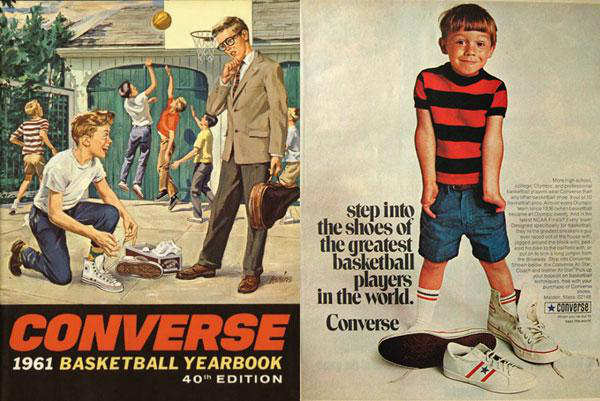

In [38]:
i = 254
pprint(df.ar[i])
pprint(df.distractor_1[i])
pprint(df.distractor_2[i])
pprint(ans_clip[i])
Image.open(join(IMAGE_FOLDER, df.image_path[i]))


14 very implausible, 21 as well

## Agreement between people and models

In [15]:
from right_wrong_paths import *

In [22]:
print(human_both_wrong.shape)
print(humans_disagree.shape)
print(models_all_right.shape)
print(models_all_wrong.shape)

(7,)
(23,)
(23,)
(114,)


In [18]:
np.array([el in models_all_wrong for el in human_both_wrong]).sum()

4

In [19]:
np.array([el in models_all_wrong for el in humans_disagree]).sum()

11